In [964]:
import pandas as pd
import numpy as np

data = pd.read_csv('data/data_indexes_moex_log_returns.csv')
data.head()


import warnings
warnings.filterwarnings("ignore")

### Поиск регрессеров для улучшения предсказания модели ###

#### 1. ВВП (в текущих ценах) ####

In [965]:
df_gdp = pd.read_excel('data/features/1.GDP.xlsx', header=None)
df_gdp.columns = ['Date', 'GDP']
df_gdp.head()

,Date,GDP
0,2011Q1,13024.799539
1,2011Q2,14434.822306
2,2011Q3,15745.583567
3,2011Q4,16908.795427
4,2012Q1,15182.776397


In [966]:
date_true = np.array([])
for date_str in df_gdp['Date']:
    date_period = pd.Period(date_str, freq='Q')
    end_date = str(date_period.end_time.date())
    date_true = np.append(date_true, end_date)

df_gdp['Date'] = date_true
df_gdp.tail()

,Date,GDP
46,2022-09-30,38245.085527
47,2022-12-31,42251.413051
48,2023-03-31,35999.130314
49,2023-06-30,39392.379668
50,2023-09-30,44151.319206


In [967]:
df_gdp['Date'] = pd.to_datetime(df_gdp['Date'])

In [968]:
df_gdp['merger'] = df_gdp['Date'].dt.quarter.astype(str) + '-' + df_gdp['Date'].dt.year.astype(str)
df_gdp.head()

,Date,GDP,merger
0,2011-03-31,13024.799539,1-2011
1,2011-06-30,14434.822306,2-2011
2,2011-09-30,15745.583567,3-2011
3,2011-12-31,16908.795427,4-2011
4,2012-03-31,15182.776397,1-2012


In [969]:
date = data.set_index('TRADEDATE')
date.index = pd.to_datetime(date.index)

date['quarter'] = date.index.quarter
date['year'] = date.index.year
date['merger'] = date['quarter'].astype(str) + '-' + date['year'].astype(str)
date = date['merger']
date

TRADEDATE
2004-12-30    4-2004
2004-12-31    4-2004
2005-01-11    1-2005
2005-01-12    1-2005
2005-01-13    1-2005
               ...  
2024-02-16    1-2024
2024-02-19    1-2024
2024-02-20    1-2024
2024-02-21    1-2024
2024-02-22    1-2024
Name: merger, Length: 4784, dtype: object

In [970]:
regressors = date.to_frame().merge(df_gdp, how='left').set_index(date.index)['GDP'].to_frame()
regressors

,GDP
TRADEDATE,
2004-12-30,NaN
2004-12-31,NaN
2005-01-11,NaN
2005-01-12,NaN
2005-01-13,NaN
...,...
2024-02-16,NaN
2024-02-19,NaN
2024-02-20,NaN


#### 2. Ключевая ставка и инфляция ####

In [971]:
df_key_rate = pd.read_excel('data/features/2.Inflation_and_the_key_rate.xlsx')
df_key_rate.head()

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Цель по инфляции
0,2.2024,16.0,7.69,4.0
1,1.2024,16.0,7.44,4.0
2,12.2023,16.0,7.42,4.0
3,11.2023,15.0,7.48,4.0
4,10.2023,15.0,6.69,4.0


<Axes: xlabel='TRADEDATE'>

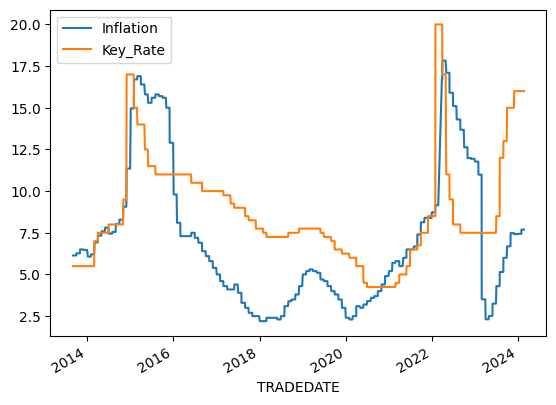

In [972]:
df_key_rate['Дата'] = df_key_rate['Дата'].astype(str)
df_key_rate['Дата'] = np.where(df_key_rate['Дата'].str[-3:] == '202', df_key_rate['Дата'] + '0', df_key_rate['Дата'])

df_key_rate['Дата'] = pd.to_datetime('01.' + df_key_rate['Дата'], format='%d.%m.%Y')

df_key_rate['merger'] = df_key_rate['Дата'].dt.month.astype(str) + '-' + df_key_rate['Дата'].dt.year.astype(str) 

regressors['merger'] = regressors.index.month.astype(str) + '-' + regressors.index.year.astype(str)

df_key_rate = df_key_rate.rename(columns={
    'Ключевая ставка, % годовых': 'Key_Rate',
    'Инфляция, % г/г': 'Inflation'
})

regressors = regressors.merge(df_key_rate[['Key_Rate', 'Inflation', 'merger']], how='left', on='merger').drop('merger', axis=1)

regressors = regressors.set_index(date.index)

regressors['Inflation'].plot(legend='Inflation')
regressors['Key_Rate'].plot(legend='Key_Rate')

#### 3. Индекс S&P 500 ####

In [973]:
df_sp500 = pd.read_csv('data/features/3.S&P_500.csv')
df_sp500['Дата'] = pd.to_datetime(df_sp500['Дата'])
df_sp500 = df_sp500.sort_values(by='Дата', ascending=True)
df_sp500 = df_sp500[['Дата', 'Изм. %']].rename(columns={
    'Дата':'date',
    'Изм. %':'snp500'
})

regressors = regressors.merge(df_sp500[['date', 'snp500']], how='left', left_index=True, right_on='date').set_index('date')

regressors.head()

,GDP,Key_Rate,Inflation,snp500
date,,,,
2004-12-30,NaN,NaN,NaN,NaN
2004-12-31,NaN,NaN,NaN,NaN
2005-01-11,NaN,NaN,NaN,"-0,60%"
2005-01-12,NaN,NaN,NaN,"0,40%"
2005-01-13,NaN,NaN,NaN,"-0,86%"


#### 4. Изменение курса USD/RUB ####

In [974]:
df_usd_rub = pd.read_csv(r'data/features/4.USD_RUB.csv')
df_usd_rub['Дата'] = pd.to_datetime(df_usd_rub['Дата'])
df_usd_rub = df_usd_rub.sort_values(by='Дата', ascending=True)
df_usd_rub = df_usd_rub[['Дата', 'Изм. %']].rename(columns={
    'Дата':'date',
    'Изм. %':'usd_rub'
})

In [975]:
regressors = regressors.merge(df_usd_rub[['date', 'usd_rub']], how='left', left_index=True, right_on='date').set_index('date')

regressors.head()

,GDP,Key_Rate,Inflation,snp500,usd_rub
date,,,,,
2004-12-30,NaN,NaN,NaN,NaN,NaN
2004-12-31,NaN,NaN,NaN,NaN,NaN
2005-01-11,NaN,NaN,NaN,"-0,60%","0,52%"
2005-01-12,NaN,NaN,NaN,"0,40%","-0,47%"
2005-01-13,NaN,NaN,NaN,"-0,86%","0,27%"


#### 5. Биткоин ####

In [976]:
df_btc = pd.read_csv('data/features/5.Bitcoin.csv')
df_btc['Дата'] = pd.to_datetime(df_btc['Дата'])
df_btc = df_btc.sort_values(by='Дата', ascending=True)
df_btc = df_btc[['Дата', 'Изм. %']].rename(columns={
    'Дата':'date',
    'Изм. %':'btc'
})

In [977]:
regressors = regressors.merge(df_btc[['date', 'btc']], how='left', left_index=True, right_on='date').set_index('date')

regressors.head()

,GDP,Key_Rate,Inflation,snp500,usd_rub,btc
date,,,,,,
2004-12-30,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-11,NaN,NaN,NaN,"-0,60%","0,52%",NaN
2005-01-12,NaN,NaN,NaN,"0,40%","-0,47%",NaN
2005-01-13,NaN,NaN,NaN,"-0,86%","0,27%",NaN


#### 6. Безработица ####

In [978]:
df_unemp = pd.read_excel('data/features/6.Unemployment.xlsx')
df_unemp.head()

,Year,Unemployment
0,2010,9.422327
1,2011,8.405232
2,2012,7.176276
3,2013,7.245033
4,2014,6.809086


In [979]:
regressors['Year'] = regressors.index.year

regressors = regressors.merge(df_unemp[['Year', 'Unemployment']], how='left', on='Year').set_index(date.index)

regressors.head()

,GDP,Key_Rate,Inflation,snp500,usd_rub,btc,Year,Unemployment
TRADEDATE,,,,,,,,
2004-12-30,NaN,NaN,NaN,NaN,NaN,NaN,2004,NaN
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,2004,NaN
2005-01-11,NaN,NaN,NaN,"-0,60%","0,52%",NaN,2005,NaN
2005-01-12,NaN,NaN,NaN,"0,40%","-0,47%",NaN,2005,NaN
2005-01-13,NaN,NaN,NaN,"-0,86%","0,27%",NaN,2005,NaN


#### 7. Финансовые вложения организаций ####

In [980]:
df_fin_invest_org = pd.read_excel('data/features/7.fin_investments_of_organizations.xlsx')
df_fin_invest_org.head()

,Год,Финансовые вложения всего (млрд руб),В том числе: в паи и акции и другие формы участия в капитале
0,2014,78604.4,10760.4
1,2015,127113.6,14860.8
2,2016,136718.9,20907.5
3,2017,165669.2,25013.3
4,2018,246503.4,22618.3


In [981]:
df_fin_invest_org = df_fin_invest_org[['Год', 'Финансовые вложения всего (млрд руб)']].\
    rename(columns={'Год': 'Year', 'Финансовые вложения всего (млрд руб)': 'tfi'})

regressors = regressors.merge(df_fin_invest_org[['Year', 'tfi']], how='left', on='Year').set_index(date.index)

regressors.head()

,GDP,Key_Rate,Inflation,snp500,usd_rub,btc,Year,Unemployment,tfi
TRADEDATE,,,,,,,,,
2004-12-30,NaN,NaN,NaN,NaN,NaN,NaN,2004,NaN,NaN
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,2004,NaN,NaN
2005-01-11,NaN,NaN,NaN,"-0,60%","0,52%",NaN,2005,NaN,NaN
2005-01-12,NaN,NaN,NaN,"0,40%","-0,47%",NaN,2005,NaN,NaN
2005-01-13,NaN,NaN,NaN,"-0,86%","0,27%",NaN,2005,NaN,NaN


#### 8. Экспорт ####

In [982]:
df_exp = pd.read_excel('data/features/8.Export.xlsx')
df_exp.head()

,Год,Экспорт (млн. долл)
0,2005,241473
1,2006,301244
2,2007,351928
3,2008,467581
4,2009,301667


In [983]:
df_exp = df_exp.\
    rename(columns={'Год': 'Year', 'Экспорт (млн. долл)': 'ex'})

regressors = regressors.merge(df_exp[['Year', 'ex']], how='left', on='Year').set_index(date.index).drop('Year', axis=1)

regressors.head()

,GDP,Key_Rate,Inflation,snp500,usd_rub,btc,Unemployment,tfi,ex
TRADEDATE,,,,,,,,,
2004-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-11,NaN,NaN,NaN,"-0,60%","0,52%",NaN,NaN,NaN,241473.0
2005-01-12,NaN,NaN,NaN,"0,40%","-0,47%",NaN,NaN,NaN,241473.0
2005-01-13,NaN,NaN,NaN,"-0,86%","0,27%",NaN,NaN,NaN,241473.0


In [984]:
regressors.usd_rub = regressors.usd_rub.str.replace('%', '').str.replace(',', '.').astype(float)
regressors.btc = regressors.btc.str.replace('%', '').str.replace(',', '.').astype(float)
regressors.snp500 = regressors.snp500.str.replace('%', '').str.replace(',', '.').astype(float)

In [985]:
regressors.to_csv('data/regressors.csv')